In [1]:
%%capture
# %%bash
!pip install groq langgraph langchain_groq langchain_community #llama-cpp-python

In [2]:
from datetime import datetime
from pydantic import BaseModel, Field, conint
from typing import List, Literal, Optional, Annotated, Union, TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, AnyMessage

class ImpromptuValidationResponse(BaseModel):
    is_valid: bool = Field(
        ...,
        description="If the transcript meets basic validation"
    )
    invalid_reasons: List[str] = Field(
        default_factory=list,
        description=(
            "List of reasons why the content is invalid. Empty list if valid. "
            "Standardized reasons: off_topic, too_short, offensive, gibberish"
        )
    )
    followup_message: str = Field(
        ...,
        description="Brief, neutral message explaining why the content was rejected or a simple acknowledgment if valid"
    )

class ImpromptuStructureEvaluationResponse(BaseModel):
    score: int = Field(..., ge=1, le=10, description="Overall structure quality 1-10")
    has_intro: bool = Field(..., description="Clear introduction with thesis statement")
    has_conclusion: bool = Field(..., description="Defined ending summary/call-to-action")
    organization: Literal["chaotic", "adequate", "logical"]
    key_strength: str = Field(..., example="Good use of examples")
    to_improve: str = Field(..., example="Better transitions needed")

class ImpromptuFluencyEvaluationResponse(BaseModel):
    # pace: Literal["too slow", "ideal", "too fast"]
    filler_words: int = Field(..., ge=0, description="Count of filler words (uh/um/like, ..etc")
    clarity: Literal["mumbled", "clear", "excellent"]
    fluency_score: int = Field(..., ge=1, le=10)

class ImpromptuEvaluation(BaseModel):
    structure: ImpromptuStructureEvaluationResponse
    fluency: ImpromptuFluencyEvaluationResponse
    feedback: str

class ImpromptuData(BaseModel):
    topic: Literal[
        "Ethics and Philosophy", "Social Issues", "Technology and Innovation",
        "Leadership and Teamwork", "Personal Development", "General Knowledge"
    ]
    topic_title: str = Field(..., description="Generated topic title")
    user_transcript_validation: ImpromptuValidationResponse
    user_transcript_evaluation: ImpromptuEvaluation

# ======== Storytelling Models ========
class StoryValidationResponse(BaseModel):
    is_valid: bool = Field(..., description="If story meets basic requirements")
    invalid_reasons: List[str] = Field(
        default_factory=list,
        description=(
            "List of reasons why the content is invalid. Empty list if valid. "
            "Standardized reasons: off_genre, too_short, no_arc, disjointed, offensive"
        )
    )
    followup_message: str = Field(
        ...,
        description="Brief, neutral message explaining why the content was rejected or a simple acknowledgment if valid"
    )

class StoryNarrativeEvaluation(BaseModel):
    narrative_score: int = Field(..., ge=1, le=10)
    character_development: int = Field(..., ge=1, le=5)
    plot_complexity: int = Field(..., ge=1, le=5)
    literary_devices: List[str] = Field(..., example=["metaphor", "dialogue"])
    key_strength: str = Field(..., example="Strong character motivations")
    to_improve: str = Field(..., example="Add more sensory details")

class StoryEngagementEvaluation(BaseModel):
    engagement_score: int = Field(..., ge=1, le=10)
    hook_quality: Literal["weak", "adequate", "strong"]
    pacing_analysis: Literal["uneven", "consistent", "excellent"]
    reader_interest: Literal["low", "moderate", "high"]
    satisfaction: Literal["unsatisfying", "adequate", "fulfilling"]

class StoryEvaluation(BaseModel):
    narrative: StoryNarrativeEvaluation
    engagement: StoryEngagementEvaluation
    feedback: str

class StoryData(BaseModel):
    genre: Literal["personal", "fictional", "historical"]
    story_prompt: str
    user_transcript_validation: StoryValidationResponse
    user_transcript_evaluation: StoryEvaluation

# ======== ConflictResolution Models ========
class ConflictValidationResponse(BaseModel):
    is_valid: bool = Field(..., description="If response meets basic requirements")
    invalid_reasons: List[Literal["off_topic", "aggressive", "avoidant", "vague"]] = Field(default_factory=list)
    followup_message: str = Field(..., description="Guidance for improvement")

class DiplomacyEvaluation(BaseModel):
    empathy_score: int = Field(..., ge=1, le=5)
    clarity_score: int = Field(..., ge=1, le=5)
    solution_focus: int = Field(..., ge=1, le=5)
    professionalism: Literal["poor", "adequate", "excellent"]
    negative_indicators: List[Literal["aggression", "avoidance", "blame"]]

class ConflictEvaluation(BaseModel):
    diplomacy: DiplomacyEvaluation
    feedback: str

class ConflictResolutionData(BaseModel):
    category: Literal[
        "Workplace/Professional", "Family Dynamics", "Community/Social",
        "Personal Relationships", "Educational/Academic"
        ]
    scenario: str
    user_transcript_validation: ConflictValidationResponse
    user_transcript_evaluation: ConflictEvaluation

# STATE
class ModuleState(BaseModel):
    name: Literal["impromptu", "storytelling", "conflict_resolution"]
    data: Union[ImpromptuData, StoryData, ConflictResolutionData]
    attempts: Optional[int] = 0
    start_time: str = Field(default_factory=lambda: datetime.now().isoformat())
    last_feedback: Optional[str] = None

class State(TypedDict):
    messages: Annotated[List[AnyMessage], add_messages]
    # completed_modules: Annotated[
    #     Literal["Impromptu Speaking", "Storytelling", "Conflict Resolution"], lambda x, y: list(set(x + y))
    #     ]
    training_sessions: List[ModuleState]
    latest_module: ModuleState
    start: str


In [3]:
import json
import os
from pydantic import BaseModel, Field, conint
from typing import List, Literal, Optional, Annotated, Union
from langchain.prompts import PromptTemplate
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain.output_parsers import PydanticOutputParser
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages.tool import ToolCall
# from langchain_community.llms import LlamaCpp
from langchain_groq import ChatGroq
from google.colab import userdata
from langchain_core.output_parsers import JsonOutputParser

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API')
model_name = "llama-3.1-8b-instant"
#"llama-3.2-3b-preview" "llama-3.1-8b-instant" "llama-3.3-70b-versatile" "llama3-8b-8192"

from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnableLambda

# ======== Enhanced Chain Factory ========
def create_chain(
    prompt_template: str,
    pydantic_model: BaseModel,
    example: dict,
    model: ChatGroq,
    temperature: float
) -> RunnableLambda:
    """Create validated chain with error recovery"""
    parser = JsonOutputParser(pydantic_object=pydantic_model)

    full_prompt = PromptTemplate(
            template=prompt_template + "\n\n{format_instructions}\nExample:\n{example}",
            input_variables=prompt_template.count("{") // 2,
            partial_variables={
                "format_instructions": parser.get_format_instructions(),
                "example": json.dumps(example, indent=2)
            }
        )\
        | model\
        | parser\
        | RunnableLambda(lambda x: pydantic_model.model_validate(x))

    return full_prompt.with_fallbacks([
        RunnableLambda(lambda _: pydantic_model(
            **example,
            followup_message="Could not process response"
        ))
    ])

# ======== Validation Chain ========
impromptu_validation_example = {
    "is_valid": False,
    "invalid_reasons": ["too_short"],
    "followup_message": "Your speech needs to be at least 50 words. Try expanding with examples."
}
impromptu_validation_chain = create_chain(
    """Validate speech transcript against topic "{topic}":
- **IMPORTAMT**: Check relevance (off_topic), if user's Transcript is not related to the topic, you should return is_valid False
- Minimum 50 words (too_short)
- No offensive content
- Clear thesis statement

Transcript: {transcript}
Topic: {topic}

Respond with JSON:""",
    ImpromptuValidationResponse,
    impromptu_validation_example,
    ChatGroq(model=model_name),
    0.3
)

# ======== Structure Analysis Chain ========
impromptu_structure_example = {
    "score": 7,
    "has_intro": True,
    "has_conclusion": False,
    "organization": "adequate",
    "key_strength": "Clear thesis statement",
    "to_improve": "Stronger conclusion needed"
}
impromptu_structure_analyzer = create_chain(
    """Analyze speech structure:
1. Check intro/conclusion presence
2. Rate organization (chaotic/adequate/logical)
3. Identify key strength/improvement

Transcript: {transcript}
Respond with JSON:""",
    ImpromptuStructureEvaluationResponse,
    impromptu_structure_example,
    ChatGroq(model=model_name),
    0.2
)

# ======== Fluency Evaluation Chain ========
impromptu_fluency_example = {
    "filler_words": 3,
    "clarity": "clear",
    "fluency_score": 8
}
impromptu_fluency_evaluator = create_chain(
    """Evaluate speech delivery:
- Count filler words (number)
- Assess clarity (mumbled/clear/excellent)
- Score fluency (1-10)

Transcript: {transcript}
Respond with JSON:""",
    ImpromptuFluencyEvaluationResponse,
    impromptu_fluency_example,
    ChatGroq(model=model_name),
    0.1
)

# ======== Feedback Chain ========
impromptu_feedback_chain = (
    PromptTemplate.from_template(
"""Generate a **motivative** feedback using these evaluation results. Do NOT mention any scores, just the feedback:

Structure: {structure}
Fluency: {fluency}

Format:
1. Start with ONE specific strength
2. Identify ONE key improvement
3. Suggest ONE practical exercise
4. Make it conversational, no additional words
5. Do NOT show any scores or explanations in the feedback
""")
    | ChatGroq(model=model_name, temperature=0.5)
)

# ======== Topic Generation Chain ========
impromptu_topic_chain = (
    PromptTemplate.from_template(
        """Generate impromptu topic about {category}.
Examples:
- "The ethics of AI in healthcare"
- "Effective remote team management"
Output ONLY the topic:"""
    )
    | ChatGroq(model=model_name, temperature=0.7)
)

# ======== Followup Chain ========
impromptu_followup_chain = (
    PromptTemplate.from_template(
        """Act as a communication coach. Provide SPECIFIC guidance to fix these validation issues:

**Topic**: {topic}
**Issues Detected**: {invalid_reasons}

**Original Attempt**:
{transcript}

**Guidance Rules**:
1. Address ONLY the listed validation issues
2. Provide 1-2 concrete steps per issue
3. Include EXAMPLE phrases/sentences
4. Keep under 75 words
5. Never invent new issues

**Example for ["off_topic"]**:
"Let's refocus on '{topic}':
1. Replace general statements with specific examples about {topic}
(e.g., 'For instance, in {topic} situations like...')
2. Remove unrelated points about leadership"

**Your Guidance**:"""
    )
    | ChatGroq(model=model_name, temperature=0.3)
)

====
<!-- # topic_prompt = PromptTemplate.from_template(
#     "Your task is to generate ONE impromptu speaking topic title related to {category}. "
#     "Rules:\n"
#     "1. Respond with ONLY the topic title\n"
#     "2. NO introduction, explanation, or additional text\n"
#     "3. NO quotation marks or formatting\n"
#     "4. DO NOT provide a speech, just the topic\n\n"
#     "Topic title:"
# )

# validation_prompt = PromptTemplate.from_template(
#     """You are a speech validation expert evaluating impromptu speeches. Your task is to validate whether the speech meets all the following criteria for the assigned topic: "{topic}".

# VALIDATION CRITERIA:
# 1. Relevance: The speech must directly address and be meaningfully related to the assigned topic "{topic}". If the transcript does not include key ideas, arguments, or examples relevant to this topic, mark it as "off_topic".
# 2. Content Quality: The speech must be at least 50 words and must not contain offensive, discriminatory, or inappropriate content. It should be coherent and logically structured.
# 3. Clarity: The speech should be clear and understandable.

# TRANSCRIPT TO VALIDATE:
# {transcript}

# INSTRUCTIONS:
# - Analyze the transcript objectively against all criteria.
# - If any criterion fails, mark the speech as invalid and list each specific reason using the standardized terms:
#   - off_topic (if the speech does not address the topic "{topic}")
#   - too_short (if the transcript contains fewer than 50 words)
#   - offensive (if it contains inappropriate or hateful language)
#   - gibberish (if the text is nonsensical)
# - Provide a brief, neutral, and actionable follow-up message explaining why the content was rejected or confirming its validity.
# - Return ONLY valid JSON matching the schema below. DO NOT include any extra text or markdown formatting.

# RESPONSE FORMAT:
# {schema}
# """
# ).partial(schema=json.dumps(ImpromptuValidationResponse.model_json_schema(), ensure_ascii=False))

# followup_prompt = PromptTemplate.from_template("""You are a patient communication coach. Help the user improve their speech using the following feedback. Guide them to address the specific issues raised. Be concise and NOT strict.

# Topic title: {topic}
# User input: {transcript}
# Validation Feedback: {validation_feedback}
# """
# )

# structure_prompt = PromptTemplate.from_template(f"""Evaluate speech structure in 3 steps:
# 1. Check for clear intro/conclusion (YES/NO)
# 2. Rate organization: chaotic/adequate/logical
# 3. Identify ONE strength and ONE improvement area

# Transcript: {{transcript}}

# Respond ONLY with JSON: {str(json.dumps(ImpromptuStructureEvaluationResponse.model_json_schema(), ensure_ascii=False)).replace("{", "{{").replace("}", "}}")}
# """)


# STRUCTURE_INSTRUCTIONS = """Evaluate speech structure by following these steps:
# 1. Check for clear introduction with thesis (YES/NO)
# 2. Check for proper conclusion (YES/NO)
# 3. Rate overall organization: [chaotic/adequate/logical]
# 4. Identify ONE main strength
# 5. Identify ONE key improvement area

# Format your response as JSON ONLY with these exact keys:
# - "score" (1-10)
# - "has_intro" (true/false)
# - "has_conclusion" (true/false)
# - "organization"
# - "key_strength"
# - "to_improve"

# Example Response:
# {{
#   "score": 7,
#   "has_intro": true,
#   "has_conclusion": false,
#   "organization": "adequate",
#   "key_strength": "Good logical flow between points",
#   "to_improve": "Add stronger concluding remarks"
# }}"""

# structure_parser = PydanticOutputParser(pydantic_object=ImpromptuStructureEvaluationResponse)

# structure_prompt = PromptTemplate(
#     template="Instructions:\n{instructions}\n\nTranscript:\n{transcript}\n\n{format_instructions}",
#     input_variables=["transcript"],
#     partial_variables={
#         "instructions": STRUCTURE_INSTRUCTIONS,
#         "format_instructions": structure_parser.get_format_instructions()
#     },
# )
# structure_chain = structure_prompt | ChatGroq(model="llama3-8b-8192", temperature=0.2) | structure_parser

# fluency_prompt = PromptTemplate.from_template(f"""Analyze speech delivery:
# 1. Count filler words (uh/um/like)
# 2. Judge pace: too slow/ideal/too fast
# 3. Assess clarity: mumbled/clear/excellent
# 4. Give 1-10 score

# Transcript: {{transcript}}

# Respond ONLY with JSON: {str(json.dumps(ImpromptuFluencyEvaluationResponse.model_json_schema(), ensure_ascii=False)).replace("{", "{{").replace("}", "}}")}""")

# feedback_prompt = PromptTemplate.from_template(f"""Generate a **motivative** feedback using these evaluation results. Do NOT mention any scores, just the feedback:

# Structure: {{structure}}
# Fluency: {{fluency}}

# Format:
# 1. Start with ONE specific strength
# 2. Identify ONE key improvement
# 3. Suggest ONE practical exercise
# 4. Keep responses under 100 words
# 5. Make it conversational, no additional words
# """)

# topic_chain = topic_prompt | ChatGroq(model=model_name, temperature=0.7)

# validation_chain = validation_prompt | ChatGroq(model=model_name, temperature=0.3)

# followup_chain = followup_prompt | ChatGroq(model=model_name, temperature=0.3)

# feedback_chain = feedback_prompt | ChatGroq(model=model_name, temperature=0.5)

# fluency_evaluator = fluency_prompt | ChatGroq(model=model_name, temperature=0.1) -->

In [4]:
import json
from pathlib import Path
from datetime import datetime
from typing import Union
from pydantic import BaseModel

class SessionTracker:
    def __init__(self, base_dir: str = "user_sessions"):
        self.base_dir = Path(base_dir)
        self.base_dir.mkdir(exist_ok=True)

    def _get_user_dir(self, user_id: str) -> Path:
        user_dir = self.base_dir / user_id
        user_dir.mkdir(exist_ok=True)
        return user_dir

    def _generate_session_filename(self) -> str:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        return f"session_{timestamp}.json"

    def save_session(
        self,
        user_id: str,
        module_state: ModuleState,
        session_metadata: dict = None
    ) -> Path:
        user_dir = self._get_user_dir(user_id)
        session_file = user_dir / self._generate_session_filename()

        session_data = {
            "user_id": user_id,
            "timestamp": datetime.now().isoformat(),
            "module_state": module_state.model_dump(),
            "metadata": session_metadata or {}
        }

        # Convert all datetime objects in session_metadata
        if session_metadata:
            session_data["metadata"] = {
                key: (value.isoformat() if isinstance(value, datetime) else value)
                for key, value in session_metadata.items()
            }

        with open(session_file, "w") as f:
            json.dump(session_data, f, indent=2)

        return session_file


    @classmethod
    def load_session(cls, user_id: str, session_file: str) -> dict:
        session_path = cls.base_dir / user_id / session_file
        with open(session_path) as f:
            return json.load(f)

In [25]:
import re
from langchain_core.runnables import RunnableConfig
from typing import List, Tuple, Union
from pydantic import BaseModel, Field, ValidationError

def generate_topic(state):

    topic_name = state["latest_module"].data.topic

    impromptu_topic = impromptu_topic_chain.invoke({"category": topic_name})

    state["latest_module"].data.topic_title = impromptu_topic.content
    state["messages"].append(impromptu_topic)

    return state

def validate_response(response: str, scheme: str, max_tries: int = 3) -> Tuple[Union[dict, str], bool]:

    try:
        parsed_response = json.loads(response)
        if parsed_response.get("properties") and len(parsed_response.keys()) > 1:
            parsed_response = parsed_response["properties"]
        ImpromptuValidationResponse(**parsed_response)
        return parsed_response, True
    except (json.JSONDecodeError, ValidationError):
        if max_tries == 0:
            return response, False

    model = ChatGroq(model=model_name, temperature=0.3)
    prompt = (
        f"Update this response: {response}\n"
        f"to follow this JSON schema: {json.dumps(ImpromptuValidationResponse.model_json_schema(), ensure_ascii=False)}\n"
        "Reply ONLY with the new JSON values with no additional properties keys.\n"
        "JSON:\n"
    )

    for attempt in range(max_tries):
        try:
            json_response_str = model.invoke(prompt).content
            parsed_json = json.loads(json_response_str)
            ImpromptuValidationResponse(**parsed_json)
            return parsed_json, True
        except json.JSONDecodeError:
            continue
        except ValidationError:
            continue
        print(f"Try {attempt + 1}/{max_tries} failed")

    return response, False

def validate_impromptu(state):
    # print("User: ", state["messages"][-1].content)
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]
    json_response = impromptu_validation_chain.invoke({
            "topic": state["latest_module"].data.topic_title,
            "transcript": user_messages[-1].content
        })

    # json_response, json_valid = validate_response(response.content, ImpromptuValidationResponse, 5)

    # if not json_valid:
    #     pattern = r'"is_valid"\s*:\s*false'
    #     match = re.search(pattern, json_response, re.IGNORECASE)
    #     if match:
    #         state["latest_module"].data.user_transcript_validation = {"is_valid": False, "invalid_reasons": json_response, "followup_message": json_response}

    #     state["latest_module"].data.user_transcript_validation = {"is_valid": True, "invalid_reasons": json_response, "followup_message": json_response}

    #     return state

    # if isinstance(json_response["is_valid"], str):
    #     if json_response["is_valid"].lower() == "true":
    #         json_response["is_valid"] = True
    #     else:
    #         json_response["is_valid"] = False

    state["latest_module"].data.user_transcript_validation = json_response

    if not json_response.is_valid:
        message = json_response.followup_message
        state["messages"].extend([
              AIMessage(
                    content="",
                    tool_calls=[ToolCall(name="validate_impromptu", args={}, id="")],
                ),
                ToolMessage(content=message, tool_call_id="", name="validate_impromptu"),
            ])

    return state

def followup(state):
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]

    response = impromptu_followup_chain.invoke({
            "invalid_reasons": str(state['latest_module'].data.user_transcript_validation),
            "topic": state['latest_module'].data.topic,
            "transcript": user_messages[-1].content
        })

    state["messages"].append(response)

    return state

def analyze_structure(state):
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]

    analysis = impromptu_structure_analyzer.invoke({"transcript": user_messages[-1].content})

    # json_response, json_valid = validate_response(analysis.content, ImpromptuStructureEvaluationResponse, 5)

    state["latest_module"].data.user_transcript_evaluation.structure = analysis

    return state

def evaluate_fluency(state):
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]

    fluency = impromptu_fluency_evaluator.invoke({"transcript": user_messages[-1].content})

    # json_response, json_valid = validate_response(fluency.content, ImpromptuFluencyEvaluationResponse, 5)

    state["latest_module"].data.user_transcript_evaluation.fluency = fluency

    return state

def generate_feedback(state):
    feedback = impromptu_feedback_chain.invoke({
        "structure": state["latest_module"].data.user_transcript_evaluation.structure,
        "fluency": state["latest_module"].data.user_transcript_evaluation.fluency,
        "feedback": state["latest_module"].data.user_transcript_evaluation.feedback
    })

    state["latest_module"].data.user_transcript_evaluation.feedback = feedback.content

    return state

def session_update_tracker(state, config):

    import time
    from datetime import datetime

    tracker = SessionTracker()

    user_id = config["configurable"]["user_id"]
    module = state["latest_module"]
    start_time = datetime.fromisoformat(module.start_time) if isinstance(module.start_time, str) else module.start_time
    module_time = (start_time - datetime.now()).total_seconds()
    module_time_formatted = str(time.strftime("%H%M%S", time.gmtime(module_time)))

    # Save session
    saved_path = tracker.save_session(
        user_id=user_id,
        module_state=module,
        session_metadata={
            "duration_seconds": module_time_formatted,
        }
    )

    state["training_sessions"].append(state["latest_module"])

    return state
    # print(f"Session saved to: {saved_path}")

In [15]:
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List, Literal
from typing_extensions import TypedDict
from langgraph.graph.message import AnyMessage, add_messages
from langgraph.checkpoint.memory import MemorySaver

builder = StateGraph(State)

# Add nodes
# builder.add_node("init_session_state", init_session_state)
builder.add_node("generate_topic", generate_topic)
builder.add_node("validate_impromptu", validate_impromptu)
builder.add_node("followup", followup)
builder.add_node("analyze_structure", analyze_structure)
builder.add_node("evaluate_fluency", evaluate_fluency)
builder.add_node("generate_feedback", generate_feedback)
builder.add_node("session_tracker", session_update_tracker)

# Build workflow
# Conditional edge
def route_impromptu_start(state):
    #vaidate UI got the topic from user first
    if not state.get("latest_module").data.topic_title:
        # print("Topic Title: ", state.get("latest_module").data.topic_title)
        return "topic_not_generated"

    return "user_input"

def route_validation(state):
    if state["latest_module"].data.user_transcript_validation.is_valid:
        return "valid"
    return "invalid"

builder.add_conditional_edges(
        START,
        route_impromptu_start,
        {
            "topic_not_generated": "generate_topic",
            "user_input": "validate_impromptu"
             }
    )
# builder.add_edge("init_session_state", "generate_topic")
builder.add_edge("generate_topic", END)
builder.add_conditional_edges(
    "validate_impromptu",
    route_validation,
    {
        "valid": "analyze_structure",
        "invalid": "followup"
    }
)
builder.add_edge("analyze_structure", "evaluate_fluency")
builder.add_edge("evaluate_fluency", "generate_feedback")
builder.add_edge("generate_feedback", "session_tracker")
builder.add_edge("session_tracker", END)
builder.add_edge("followup", END)

checkpointer = MemorySaver()
impromptu_graph = builder.compile(checkpointer=checkpointer)

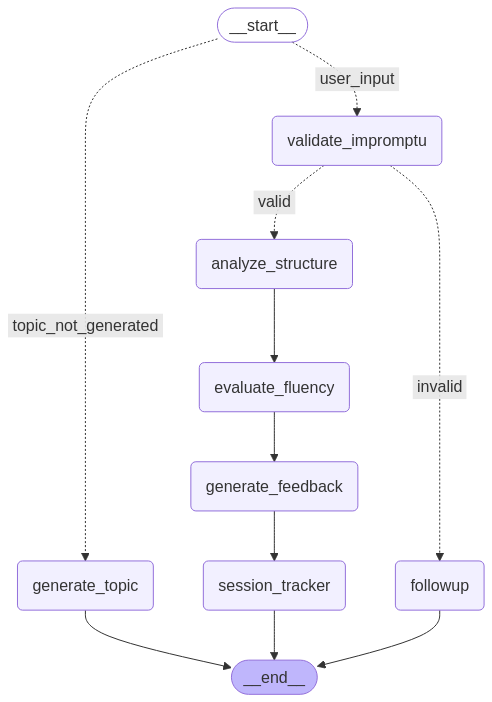

In [16]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        impromptu_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [114]:
thread_id = "promptu_02"
user_id = "alaa_sedeeq"
config = {
    "recursion_limit": 30,
    "configurable": {
        "thread_id": thread_id,
        "user_id": user_id
        }
}

state = {
    "messages": [],
    "training_sessions": [],
    "latest_module": ModuleState(
        name="impromptu",
        data=ImpromptuData(
            topic="Ethics and Philosophy",
            topic_title="",
            user_transcript_validation=ImpromptuValidationResponse(
                is_valid=False, invalid_reasons=[], followup_message=""
                ),
            user_transcript_evaluation=ImpromptuEvaluation(
                structure=ImpromptuStructureEvaluationResponse(
                    score=1, has_intro=False,
                    has_conclusion=False,
                    organization="chaotic",
                    key_strength="",
                    to_improve=""
                    ),
                fluency=ImpromptuFluencyEvaluationResponse(
                  filler_words=0,
                  clarity="mumbled",
                  fluency_score=1
                  ),
                feedback=""
            )
    )
    )
    }

state["messages"] = []

state["messages"].append(HumanMessage(content="START"))
state = impromptu_graph.invoke(state, config)

test_transcript_1 = """
Uh, leadership is important because... like, leaders need to guide teams.
First, communication matters. Second, empathy. Third, decision-making.
In conclusion, good leaders are crucial.
"""
state["messages"].append(HumanMessage(content=test_transcript_1))
state = impromptu_graph.invoke(state, config)

# state = generate_topic(state)
# state = validate_impromptu(state)
# state = analyze_structure(state)
# state = evaluate_fluency(state)
# state = generate_feedback(state)
# print(state)

test_transcript_2="""Okay, so... social media influencers, right? They're everywhere these days. But let's talk about the ethical side of this. Uh, first off, there's the transparency issue. Like, when someone promotes a skincare product with flawless filters, but doesn't disclose they're using Photoshop... that's misleading, you know?

Then there's the whole... [pause] the whole targeting of vulnerable audiences. I mean, teenagers seeing constant '#ad posts about weight loss teas? That can really mess with self-esteem. But wait – who's responsible here? The influencer? The brand? Or maybe the platforms allowing this?

I remember this one case where a influencer promoted a crypto scam. People lost thousands! That's... that's just wrong. But on the flip side, some creators are using their platforms for good – like promoting sustainability while being upfront about sponsorships.

So ultimately, I think we need clearer ethical guidelines. Maybe... mandatory disclosure labels? Or accountability measures? Because right now, it feels like the Wild West of advertising, and regular users are paying the price."""

state["messages"].append(HumanMessage(content=test_transcript_2))

state = impromptu_graph.invoke(state, config)

# print(state)

In [115]:
state

{'messages': [HumanMessage(content='START', additional_kwargs={}, response_metadata={}, id='ab11b8bd-d3df-4fba-b75b-36859f27499d'),
  AIMessage(content='"The moral implications of virtual reality on human identity"', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 68, 'total_tokens': 79, 'completion_time': 0.014666667, 'prompt_time': 0.003665017, 'queue_time': 0.272093554, 'total_time': 0.018331684}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_fd87957473', 'finish_reason': 'stop', 'logprobs': None}, id='run-33562890-d2f4-48a1-ba98-166a55d01e47-0', usage_metadata={'input_tokens': 68, 'output_tokens': 11, 'total_tokens': 79}),
  HumanMessage(content='\nUh, leadership is important because... like, leaders need to guide teams.\nFirst, communication matters. Second, empathy. Third, decision-making.\nIn conclusion, good leaders are crucial.\n', additional_kwargs={}, response_metadata={}, id='c1e9f8bf-1fc0-44be-8281-4d36ed

In [116]:
# ImpromptuEvaluation.__dict__
print("One of the standout aspects of your writing is the good use of examples to illustrate the ethical concerns, which really helps to make the content more engaging and relatable. \n\nTo take your writing to the next level, I think it would be helpful to work on creating clearer transitions between ideas. This will help to make the content flow more smoothly and make it easier for readers to follow your train of thought.\n\nTo practice this, I'd like you to try rewriting a paragraph from your essay, paying close attention to how you connect each idea to the one before it. See if you can use transitional phrases or words to help guide the reader through the content.")

One of the standout aspects of your writing is the good use of examples to illustrate the ethical concerns, which really helps to make the content more engaging and relatable. 

To take your writing to the next level, I think it would be helpful to work on creating clearer transitions between ideas. This will help to make the content flow more smoothly and make it easier for readers to follow your train of thought.

To practice this, I'd like you to try rewriting a paragraph from your essay, paying close attention to how you connect each idea to the one before it. See if you can use transitional phrases or words to help guide the reader through the content.


In [27]:
# ======== Storytelling Chains ========
# Story Prompt Generation
# Story Prompt Generation
story_prompt_chain = (
    PromptTemplate.from_template(
        """Generate a story starter for {genre} genre.
Examples:
- Personal: "Write about a time you faced an unexpected challenge..."
- Fictional: "In a world where memories are currency..."
- Historical: "Describe a day in the life of a 1920s factory worker..."

Output ONLY the prompt:"""
    )
    | ChatGroq(model=model_name, temperature=0.7)
)

# Story Validation Chain
story_validation_example = {
    "is_valid": False,
    "invalid_reasons": ["too_short"],
    "followup_message": "Expand story to at least 300 words"
}

story_validation_chain = create_chain(
    """Validate story against these criteria:
1. Matches {genre} genre
2. Minimum 300 words
3. Clear beginning-middle-end
4. Logical plot progression
5. No offensive content

Story: {story}

Respond with JSON:""",
    StoryValidationResponse,
    story_validation_example,
    ChatGroq(model=model_name),
    0.3
)

# Narrative Analysis Chain
story_narrative_example = {
    "narrative_score": 7,
    "character_development": 3,
    "plot_complexity": 4,
    "literary_devices": ["metaphor", "flashback"],
    "key_strength": "Strong emotional tension",
    "to_improve": "Develop secondary characters"
}

story_narrative_analyzer = create_chain(
    """Analyze story narrative:
1. Character depth/development
2. Plot complexity
3. Literary devices used
4. Emotional arc quality

Story: {story}
Respond with JSON:""",
    StoryNarrativeEvaluation,
    story_narrative_example,
    ChatGroq(model=model_name),
    0.2
)

# Engagement Analysis Chain
story_engagement_example = {
    "engagement_score": 8,
    "hook_quality": "strong",
    "pacing_analysis": "consistent",
    "reader_interest": "high",
    "satisfaction": "adequate"
}

story_engagement_analyzer = create_chain(
    """Evaluate story engagement:
1. Opening hook impact
2. Pacing analysis
3. Reader interest maintenance
4. Ending satisfaction

Story: {story}
Respond with JSON:""",
    StoryEngagementEvaluation,
    story_engagement_example,
    ChatGroq(model=model_name),
    0.2
)

# ======== Followup Chain ========
story_followup_chain = (
    PromptTemplate.from_template(
        """Act as a communication coach. Provide SPECIFIC guidance to fix these story validation issues:

**Genre**: {genre}
**Issues Detected**: {invalid_reasons}

**Original Attempt**:
{story}

**Guidance Rules**:
1. Address ONLY the listed validation issues
2. Provide 1-2 concrete steps per issue
3. Include EXAMPLE phrases/sentences
4. Keep under 100 words
5. Never invent new issues

**Example for ["off_genre"]**:
"Let's refocus on '{genre}':
1. Replace general statements with specific examples about {genre}
(e.g., 'For instance, in {genre} situations like...')

**Your Guidance**:"""
    )
    | ChatGroq(model=model_name, temperature=0.3)
)

# Story Feedback Chain
story_feedback_chain = (
    PromptTemplate.from_template(
        """Generate writing feedback using:
Narrative: {narrative}
Engagement: {engagement}

Format:
1. Highlight strongest element
2. Suggest ONE key improvement
3. Recommend writing exercise
4. Keep under 100 words

Example:
"Your vivid characters (strength) carry the story. Deepen the setting descriptions (improvement). Practice describing locations using 3 senses (exercise)."
"""
    )
    | ChatGroq(model=model_name, temperature=0.5)
)

# ======== Story Graph Components ========
def generate_story_prompt(state):
    genre = state["latest_module"].data.genre
    story_prompt = story_prompt_chain.invoke({"genre": genre})
    state["latest_module"].data.story_prompt = story_prompt.content
    return state

def validate_story(state):
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]

    validation = story_validation_chain.invoke({
        "story": user_messages[-1].content,
        "genre": state["latest_module"].data.genre
    })
    state["latest_module"].data.user_transcript_validation = validation
    return state

def story_followup(state):
    user_messages = [m for m in state["messages"] if isinstance(m, HumanMessage)]

    response = story_followup_chain.invoke({
            "invalid_reasons": str(state['latest_module'].data.user_transcript_validation),
            "genre": state['latest_module'].data.genre,
            "story": user_messages[-1].content
        })

    state["messages"].append(response)

    return state

def analyze_narrative(state):
    analysis = story_narrative_analyzer.invoke({
        "story": state["messages"][-1].content
    })
    state["latest_module"].data.user_transcript_evaluation.narrative = analysis
    return state

def evaluate_engagement(state):
    evaluation = story_engagement_analyzer.invoke({
        "story": state["messages"][-1].content
    })
    state["latest_module"].data.user_transcript_evaluation.engagement = evaluation
    return state

def generate_story_feedback(state):
    feedback = story_feedback_chain.invoke({
        "narrative": state["latest_module"].data.user_transcript_evaluation.narrative,
        "engagement": state["latest_module"].data.user_transcript_evaluation.engagement
    })
    state["latest_module"].data.user_transcript_evaluation.feedback = feedback.content
    return state

# ======== Storytelling Graph ========
# ======== Update State Graph ========
builder = StateGraph(State)

# Add Storytelling Nodes
builder.add_node("generate_story_prompt", generate_story_prompt)
builder.add_node("validate_story", validate_story)
builder.add_node("analyze_narrative", analyze_narrative)
builder.add_node("evaluate_engagement", evaluate_engagement)
builder.add_node("generate_story_feedback", generate_story_feedback)
builder.add_node("story_followup", story_followup)
builder.add_node("session_tracker", session_update_tracker)

# Define Conditional Edges
def route_story_start(state):
    #vaidate UI got the topic from user first
    if not state.get("latest_module").data.story_prompt:
        return "story_prompt_not_generated"
    return "user_input"

def route_story_validation(state):
    if state["latest_module"].data.user_transcript_validation.is_valid:
        return "valid_story"
    return "invalid_story"

# Storytelling Workflow

builder.add_edge("generate_story_prompt", END)
builder.add_edge("analyze_narrative", "evaluate_engagement")
builder.add_edge("evaluate_engagement", "generate_story_feedback")
builder.add_edge("generate_story_feedback", "session_tracker")
builder.add_edge("session_tracker", END)
builder.add_edge("story_followup", END)

# Connect to Main Graph
builder.add_conditional_edges(
    START,
    route_story_start,
    {
        "story_prompt_not_generated": "generate_story_prompt",
        "user_input": "validate_story"
    }
)
builder.add_conditional_edges(
    "validate_story",
    route_story_validation,
    {
        "valid_story": "analyze_narrative",
        "invalid_story": "story_followup"
    }
)
# Compile Graph
checkpointer = MemorySaver()
story_graph = builder.compile(checkpointer=checkpointer)

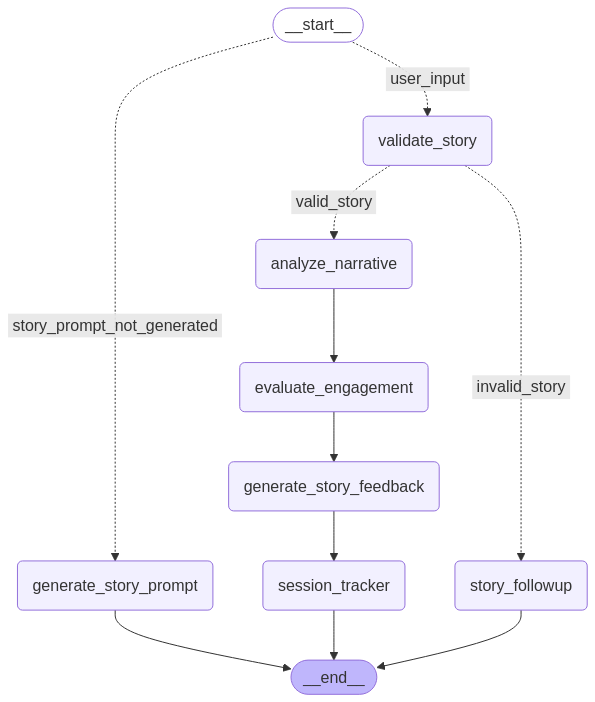

In [29]:
# Visualize Graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        story_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [157]:
# ======== Test Configuration ========
thread_id = "story_0000"
user_id = "test_user"
config = {
    "recursion_limit": 30,
    "configurable": {
        "thread_id": thread_id,
        "user_id": user_id
    }
}

# ======== Test 1: Failed Validation (Too Short) ========
print("=== STARTING TEST 1: INVALID STORY ===")
state = {
    "messages": [],
    "training_sessions": [],
    "latest_module": ModuleState(
        name="storytelling",
        data=StoryData(
            genre="personal",
            story_prompt="",
            user_transcript_validation=StoryValidationResponse(  # Fixed field name
                is_valid=False,
                invalid_reasons=[],
                followup_message=""
            ),
            user_transcript_evaluation=StoryEvaluation(  # Fixed field name
                narrative=StoryNarrativeEvaluation(
                    narrative_score=1,
                    character_development=1,
                    plot_complexity=1,
                    literary_devices=[],
                    key_strength="",
                    to_improve=""
                ),
                engagement=StoryEngagementEvaluation(
                    engagement_score=1,
                    hook_quality="weak",
                    pacing_analysis="uneven",
                    reader_interest="low",
                    satisfaction="unsatisfying"
                ),
                feedback=""
            )
        )
    )
}

# Generate story prompt
state["messages"].append(HumanMessage(content="START"))
state = story_graph.invoke(state, config)
print("\nGenerated Story Prompt:", state["latest_module"].data.story_prompt)

# Submit invalid story (too short)
test_story_1 = """It was a rainy day. I forgot my umbrella.
I ran to the bus stop. Got wet. The end."""
state["messages"].append(HumanMessage(content=test_story_1))
state = story_graph.invoke(state, config)

# ======== Test 2: Successful Story Submission ========
# Submit valid story
test_story_2 = """The hospital monitor beeped steadily as I clutched my father's hand.
At 16, I never imagined I'd be making life-altering decisions. His cancer diagnosis
came like a summer storm - sudden and drenching. Dr. Martinez explained the treatment
options, her voice softening when mentioning the risks.

I remember the smell of antiseptic mixing with mom's lavender perfume as we debated.
Uncle Mark argued for aggressive treatment, while Aunt Lisa worried about quality of life.
My childhood memories of dad coaching soccer games clashed with the frail figure in the bed.

In the end, we chose palliative care. Watching his peaceful final weeks taught me more
about love and loss than any teenage experience should. Now I volunteer at the hospice,
sharing our story to help others navigate these impossible choices."""

state["messages"].append(HumanMessage(content=test_story_2))
state = story_graph.invoke(state, config)

=== STARTING TEST 1: INVALID STORY ===

Generated Story Prompt: Write about a summer spent at your grandparents' old family cabin.


In [159]:
state

{'messages': [HumanMessage(content='START', additional_kwargs={}, response_metadata={}, id='3fb0b0ec-8295-4484-b781-72c892168f65'),
  HumanMessage(content='It was a rainy day. I forgot my umbrella. \nI ran to the bus stop. Got wet. The end.', additional_kwargs={}, response_metadata={}, id='c56169b8-cb93-41e0-bd60-36dee5848a6c'),
  AIMessage(content="Let's address the story validation issues:\n\n**too_short**:\n1. Expand the story by adding more details to each scene. \n   (e.g., 'As I stood at the bus stop, the rain poured down, soaking my shoes.')\n2. Introduce a turning point or conflict to create tension. \n   (e.g., 'Just as I was about to give up, a stranger offered me their umbrella.')\n\n**disjointed**:\n1. Use transitional phrases to connect scenes and create a flow. \n   (e.g., 'As I stood at the bus stop, I realized I had forgotten my umbrella. I quickly ran back home to grab a jacket.')\n2. Establish a clear beginning, middle, and end structure. \n   (e.g., 'I started my day

In [30]:
# Scenario Generation Chain
conflict_scenario_chain = (
    PromptTemplate.from_template(
        """Generate a conflict scenario about {category}.
Examples:
- "Your teammate missed a deadline affecting your project"
- "A client is upset about delayed deliverables"
- "A colleague takes credit for your work"

Output ONLY the scenario:"""
    )
    | ChatGroq(model=model_name, temperature=0.7)
    | RunnableLambda(lambda x: x.content.strip())
)

# Response Validation Chain
conflict_validation_example = {
    "is_valid": False,
    "invalid_reasons": ["aggressive"],
    "followup_message": "Avoid accusatory language like 'you always'"
}

# Response Validation Chain (corrected)
conflict_validation_chain = create_chain(
    """Validate conflict response STRICTLY. Respond ONLY with JSON:

Validation Criteria:
1. Check for aggression (words like 'you always', 'your fault')
2. Detect avoidance ('not my problem', 'don't care')
3. Verify relevance to scenario
4. Minimum 50 words

Formatting Rules:
- NO explanations
- NO code blocks
- ONLY valid JSON

Example Response:
{{"is_valid": false, "invalid_reasons": ["aggressive"], "followup_message": "Avoid 'you' statements"}}

Category: {category}
Scenario: {scenario}
Response: {response}

JSON:""",
    ConflictValidationResponse,
    conflict_validation_example,
    ChatGroq(model=model_name, temperature=0.1),
    0.3
)

# Diplomacy Evaluation Chain
diplomacy_evaluation_example = {
    "empathy_score": 4,
    "clarity_score": 3,
    "solution_focus": 5,
    "professionalism": "excellent",
    "negative_indicators": []
}

diplomacy_evaluator = create_chain(
    """Evaluate diplomatic response. Return ONLY JSON:

Evaluation Criteria:
1. Empathy (1-5): Acknowledgement of others' perspectives
2. Clarity (1-5): Directness without aggression
3. Solution Focus (1-5): Concrete suggestions
4. Professionalism: Appropriate tone
5. Negative Indicators: Any hostile language

Response Format:
{
  "empathy_score": 4,
  "clarity_score": 3,
  "solution_focus": 5,
  "professionalism": "excellent",
  "negative_indicators": []
}

Scenario: {scenario}
Response: {response}

JSON:""",
    DiplomacyEvaluation,
    diplomacy_evaluation_example,
    ChatGroq(model=model_name, temperature=0.1),
    0.2
)

# Feedback Chain
conflict_feedback_chain = (
    PromptTemplate.from_template(
        """Generate diplomatic feedback using:
{diplomacy}

Format:
1. Highlight strongest diplomatic skill
2. Identify ONE key improvement
3. Suggest role-play exercise
4. Keep under 100 words

Example:
"Great empathy in acknowledging feelings (strength). Work on clearer action steps (improvement). Practice rephrasing 'You' statements as 'We' solutions."
"""
    )
    | ChatGroq(model=model_name, temperature=0.5)
)

def generate_conflict_scenario(state):
    category = state["latest_module"].data.category
    scenario = conflict_scenario_chain.invoke({
        "category": category
    })
    state["latest_module"].data.scenario = scenario
    return state

def validate_conflict_response(state):
    response = state["messages"][-1].content
    category = state["latest_module"].data.category
    validation = conflict_validation_chain.invoke({
        "category": category,
        "scenario": state["latest_module"].data.scenario,
        "response": response
    })
    state["latest_module"].data.user_transcript_validation = validation
    return state

def evaluate_diplomacy(state):
    evaluation = diplomacy_evaluator.invoke({
        "scenario": state["latest_module"].data.scenario,
        "response": state["messages"][-1].content
    })
    state["latest_module"].data.user_transcript_evaluation.diplomacy = evaluation
    return state

def generate_conflict_feedback(state):
    feedback = conflict_feedback_chain.invoke({
        "diplomacy": state["latest_module"].data.user_transcript_evaluation.diplomacy
    })
    state["latest_module"].data.user_transcript_evaluation.feedback = feedback.content
    return state

def conflict_followup(state):
    guidance = state["latest_module"].data.user_transcript_validation.followup_message
    state["messages"].append(AIMessage(
        content=guidance,
        additional_kwargs={
            "retry_instructions": "Revise your response focusing on: " +
            ", ".join(state["latest_module"].data.user_transcript_validation.invalid_reasons)
        }
    ))
    return state


builder = StateGraph(State)

# Add Conflict Resolution Nodes
builder.add_node("generate_conflict_scenario", generate_conflict_scenario)
builder.add_node("validate_conflict_response", validate_conflict_response)
builder.add_node("evaluate_diplomacy", evaluate_diplomacy)
builder.add_node("generate_conflict_feedback", generate_conflict_feedback)
builder.add_node("conflict_followup", conflict_followup)
builder.add_node("session_tracker", session_update_tracker)

# Define Conditional Edges
def route_conflit_story_start(state):
    if not state["latest_module"].data.category:
        return "conflict_scenario_not_generated"
    return "user_input"

def route_conflict_validation(state):
    if state["latest_module"].data.user_transcript_validation.is_valid:
        return "valid_response"
    return "invalid_response"

builder.add_conditional_edges(
    "validate_conflict_response",
    route_conflict_validation,
    {
        "valid_response": "evaluate_diplomacy",
        "invalid_response": "conflict_followup"
    }
)

# Conflict Resolution Workflow
# builder.add_edge("generate_conflict_scenario", "validate_conflict_response")
builder.add_edge("evaluate_diplomacy", "generate_conflict_feedback")
builder.add_edge("generate_conflict_feedback", "session_tracker")
builder.add_edge("generate_conflict_scenario", END)
builder.add_edge("conflict_followup", END)
builder.add_edge("session_tracker", END)

# Connect to Main Graph
builder.add_conditional_edges(
    START,
    route_conflit_story_start,
    {
        "conflict_scenario_not_generated": "generate_conflict_scenario",
        "user_input": "validate_conflict_response"
    }
)

# Compile Graph
checkpointer = MemorySaver()
conflict_graph = builder.compile(checkpointer=checkpointer)

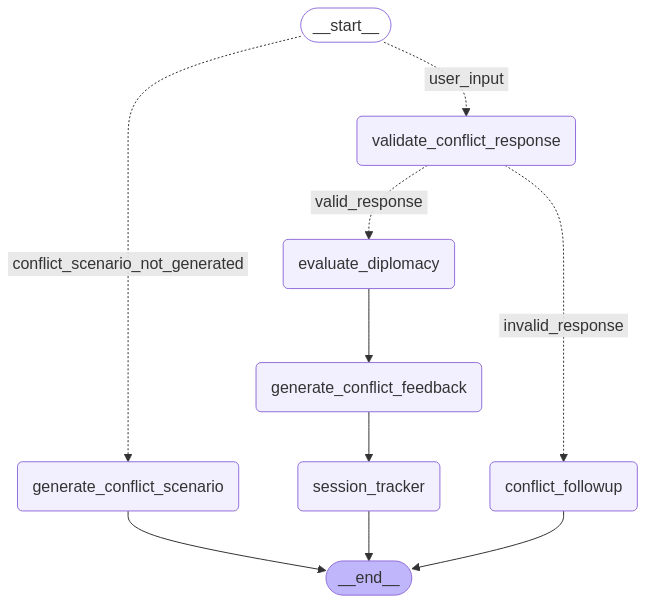

In [22]:
# Visualize Graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        conflict_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [23]:
# ======== Test Configuration ========
thread_id = "conflict_01"
user_id = "test_user"
config = {
    "recursion_limit": 30,
    "configurable": {
        "thread_id": thread_id,
        "user_id": user_id
    }
}

# ======== Test 1: Failed Validation (Aggressive Response) ========
state = {
    "messages": [],
    "training_sessions": [],
    "latest_module": ModuleState(
        name="conflict_resolution",
        data=ConflictResolutionData(
            category="Workplace/Professional",  # Add required category
            scenario="",
            user_transcript_validation=ConflictValidationResponse(  # Correct field name
                is_valid=False,
                invalid_reasons=[],
                followup_message=""
            ),
            user_transcript_evaluation=ConflictEvaluation(  # Correct field name
                diplomacy=DiplomacyEvaluation(
                    empathy_score=1,
                    clarity_score=1,
                    solution_focus=1,
                    professionalism="poor",
                    negative_indicators=[]
                ),
                feedback=""
            )
        )
    )
}

# Generate conflict scenario
state["messages"].append(HumanMessage(content="START"))
state = conflict_graph.invoke(state, config)

# Submit invalid response
test_response_1 = "This is all your fault! You never listen to anyone's ideas!"
state["messages"].append(HumanMessage(content=test_response_1))
state = conflict_graph.invoke(state, config)

# Submit valid response
test_response_2 = """I understand this situation is frustrating for both of us.
Could we schedule a time to review what's causing the delays?
Maybe we can find a solution that works for everyone."""
state["messages"].append(HumanMessage(content=test_response_2))
state = conflict_graph.invoke(state, config)

In [24]:
state

{'messages': [HumanMessage(content='START', additional_kwargs={}, response_metadata={}, id='1fee3c58-568d-464b-b60d-3c0a74f2a4a1'),
  AIMessage(content="Avoid 'you' statements and focus on the issue at hand", additional_kwargs={'retry_instructions': 'Revise your response focusing on: aggressive'}, response_metadata={}, id='004f3f74-211c-432c-ae1c-add542ee55bd'),
  HumanMessage(content="This is all your fault! You never listen to anyone's ideas!", additional_kwargs={}, response_metadata={}, id='4bb626fc-397f-4049-b6a2-fdc72a266268'),
  AIMessage(content="Avoid 'you' statements and focus on the issue at hand. This response is not relevant to the scenario and does not address the problem in a constructive manner.", additional_kwargs={'retry_instructions': 'Revise your response focusing on: aggressive, aggressive'}, response_metadata={}, id='709d15ee-b490-48aa-950f-6fb70f5cb755'),
  HumanMessage(content="I understand this situation is frustrating for both of us. \nCould we schedule a time 

In [60]:
def filter(state):
    return state

builder = StateGraph(State)

# Add Conflict Resolution Nodes
builder.add_node("filter", filter)
builder.add_node("session_tracker", session_update_tracker)
builder.add_node("impromptu_speaking", impromptu_graph)
builder.add_node("storytelling", story_graph)
builder.add_node("conflict_resolution", conflict_graph)

# Define Conditional Edges
def route_filter(state):
    if state["latest_module"].name == "impromptu":
        return "impromptu_speaking"
    elif state["latest_module"].name == "storytelling":
        return "storytelling"
    return "conflict_resolution"

def route_end(state):
    if state["latest_module"].data.user_transcript_evaluation.feedback:
        return "session_ended"
    return "session_continue"

builder.add_edge(START, "filter")
builder.add_conditional_edges(
    "filter",
    route_filter,
    ["impromptu_speaking", "storytelling", "conflict_resolution"]
)
builder.add_conditional_edges(
    "impromptu_speaking",
    route_end,
    {
        "session_ended": "session_tracker",
        "session_continue": END
    }
)
builder.add_conditional_edges(
    "storytelling",
    route_end,
    {
        "session_ended": "session_tracker",
        "session_continue": END
    }
)
builder.add_conditional_edges(
    "conflict_resolution",
    route_end,
    {
        "session_ended": "session_tracker",
        "session_continue": END
    }
)
builder.add_edge("session_tracker", END)

# Compile Graph
checkpointer = MemorySaver()
training_graph = builder.compile(checkpointer=checkpointer)

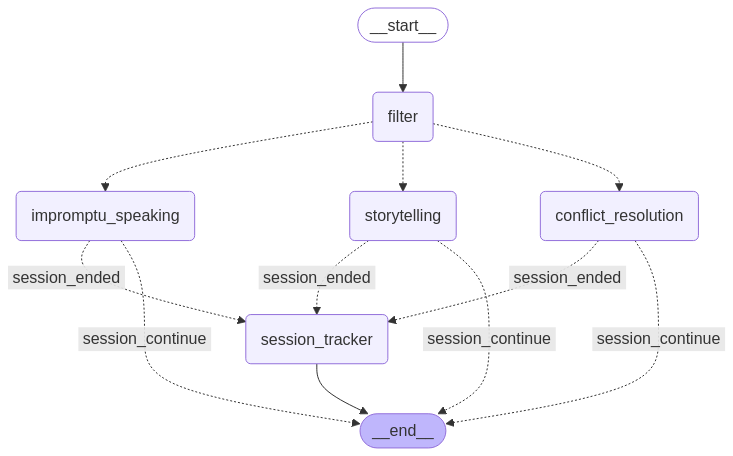

In [52]:
# Visualize Graph
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        training_graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [63]:
# ======== Test Configuration ========
thread_id = "conflict_55"
user_id = "test_user"
config = {
    "recursion_limit": 30,
    "configurable": {
        "thread_id": thread_id,
        "user_id": user_id
    }
}

# ======== Test 1: Failed Validation (Aggressive Response) ========
state = {
    "messages": [],
    "training_sessions": [],
    "latest_module": ModuleState(
        name="conflict_resolution",
        data=ConflictResolutionData(
            category="Workplace/Professional",  # Add required category
            scenario="",
            user_transcript_validation=ConflictValidationResponse(  # Correct field name
                is_valid=False,
                invalid_reasons=[],
                followup_message=""
            ),
            user_transcript_evaluation=ConflictEvaluation(  # Correct field name
                diplomacy=DiplomacyEvaluation(
                    empathy_score=1,
                    clarity_score=1,
                    solution_focus=1,
                    professionalism="poor",
                    negative_indicators=[]
                ),
                feedback=""
            )
        )
    )
}

# Generate conflict scenario
state["messages"].append(HumanMessage(content="START"))
state = training_graph.invoke(state, config)

# Submit invalid response
test_response_1 = "This is all your fault! You never listen to anyone's ideas!"
state["messages"].append(HumanMessage(content=test_response_1))
state = training_graph.invoke(state, config)

# Submit valid response
test_response_2 = """I understand this situation is frustrating for both of us.
Could we schedule a time to review what's causing the delays?
Maybe we can find a solution that works for everyone."""
state["messages"].append(HumanMessage(content=test_response_2))
state = training_graph.invoke(state, config)

In [64]:
state

{'messages': [HumanMessage(content='START', additional_kwargs={}, response_metadata={}, id='2bd6a3a2-cc22-4ac0-8282-6602874d2e92'),
  AIMessage(content="Avoid accusatory language like 'you always'", additional_kwargs={'retry_instructions': 'Revise your response focusing on: aggressive'}, response_metadata={}, id='5d2d5fa0-f26b-4e91-bbfd-a033ce92c554'),
  HumanMessage(content="This is all your fault! You never listen to anyone's ideas!", additional_kwargs={}, response_metadata={}, id='64824c48-f3ed-4b3c-b4d7-8cfcd7d08343'),
  AIMessage(content='Response is not relevant to the workplace scenario and contains aggressive language', additional_kwargs={'retry_instructions': 'Revise your response focusing on: aggressive, off_topic'}, response_metadata={}, id='3466224f-ffba-42f4-96d0-ef0dc1974f45'),
  HumanMessage(content="I understand this situation is frustrating for both of us. \nCould we schedule a time to review what's causing the delays? \nMaybe we can find a solution that works for ever

In [ ]:
import torch
from abc import ABC, abstractmethod

class LLMBase(ABC):
    """Base class for LLM implementations"""
    def __init__(self, model_name, system_prompt):
        self.model_name = model_name
        self.system_prompt = system_prompt
        self.model = None
        self.tokenizer = None
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

    @abstractmethod
    def load_model(self):
        """Load model and tokenizer"""
        pass

    @abstractmethod
    def tokenize(self, text):
        """Tokenize input text"""
        pass

    @abstractmethod
    def generate(self, input_ids, **kwargs):
        """Generate text from tokenized input"""
        pass

    @abstractmethod
    def detokenize(self, output_ids):
        """Convert output tokens to text"""
        pass

    def __call__(self, prompt, **generation_kwargs):
        """Complete inference pipeline"""
        inputs = self.tokenize(prompt)
        outputs = self.generate(inputs, **generation_kwargs)
        return self.detokenize(outputs)

from groq import Groq

class GroqLLM(LLMBase):
    def __init__(self, model_name, system_prompt=None):
        super().__init__(model_name, system_prompt)
        self.client = Groq(
            api_key="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"
            )

    def load_model(self):
        pass

    def tokenize(self, text):
        pass

    def generate(self, inputs, **kwargs):
      chat_completion = self.client.chat.completions.create(
          messages=[
              {
                  "role": "system",
                  "content": self.system_prompt,
              },
              {
                  "role": "user",
                  "content": inputs,
              }
          ],
          model=self.model_name,
          **kwargs
      )

      return chat_completion.choices[0].message.content

    def detokenize(self, output_ids):
        raise NotImplementedError("Groq does not support detokenization")

In [ ]:
from typing import Dict, Any
from pydantic import BaseModel

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage

class Node:
    def __init__(
        self,
        name: str,
        system_prompt: str,
    ) -> None:
        self.name = name
        self.system_prompt = system_prompt
        self.llm = GroqLLM(model_name=model_name, system_prompt=self.system_prompt)
            # model=CONFIG.llms.groq.model_name, temperature=CONFIG.llms.groq.temperature)

    def _validate_response(self, response):

        if not response:
            return False

        return True

    def __call__(self, state: State, config: RunnableConfig) -> Dict[str, Any]:
        # logger.info(f"Current Node: {self.name.title()}\n")

        llm_input = state["messages"][-1]["content"]

        while True:
            response = self.llm.invoke({"messages": llm_input})

            if self._validate_response(response):
                break

            llm_input.append(HumanMessage(self.fall_back_msg))

        return
        # return self._process_response(state, response)

"Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?"